In [76]:
import geopandas as gpd
import shapely as sh
import os
import pyrosm
import h3
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd

In [3]:
def get_extract(data_dir, location):
    osm_data = pyrosm.get_data(location, directory=data_dir)
    print("Data was downloaded to:", osm_data)
    return osm_data

In [6]:
def get_supermarkets(extract_file, boundry):
    boundry_geom = boundry['geometry'].values[0]
    print('Loading extract')
    tor_osm = pyrosm.OSM(extract_file, boundry_geom)
    print('Getting supermarkets')
    return tor_osm.get_data_by_custom_criteria(custom_filter={'shop':['supermarket']}, extra_attributes=['brand'], keep_ways=False)

In [63]:
def plot_df(df, column=None, ax=None):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=3857)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)


def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)


def plot_shape_and_cells(shape, res=9):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()


In [116]:
def create_hex(boundry, res=7):
    boundry_h3 = h3.geo_to_h3shape(boundry.iloc[0].geometry.__geo_interface__)
    return h3.h3shape_to_cells(boundry_h3, res)

In [7]:
if __name__ == '__main__':
    os.chdir('/Users/benpage/Documents/GitHub/r5food/data/')
    extract_name = 'Toronto.osm.pbf'
    location = 'Toronto'
    data_dir = '/Users/benpage/Documents/GitHub/r5food/data/'

    tor_boundry = gpd.read_file('tor_boundry.geojson')
    supermarkets = get_supermarkets(extract_name, tor_boundry)
    supermarkets.to_file('supermarkets.geoJSON')
    
    # neighborhoods = gpd.read_file('tor_neigh.geojson')
    # boundry = neighborhoods.dissolve()
    # boundry_geom = boundry['geometry'].values[0]
    
    # tor_file = get_extract(data_dir, location)
    # boundry_geom = boundry['geometry'].values[0]
    # tor_osm = pyrosm.OSM(tor_file, boundry_geom)
    # supermarkets = tor_osm.get_data_by_custom_criteria(custom_filter={'shop':['supermarket']}, extra_attributes=['brand'], keep_ways=False)

Loading extract
Getting supermarkets


In [79]:
def h3_to_polygon(h3_id):
    """Convert an H3 cell ID to a Shapely Polygon"""
    coordinates = h3.h3_to_geo_boundary(h3_id, geo_json=True)
    return Polygon(coordinates)

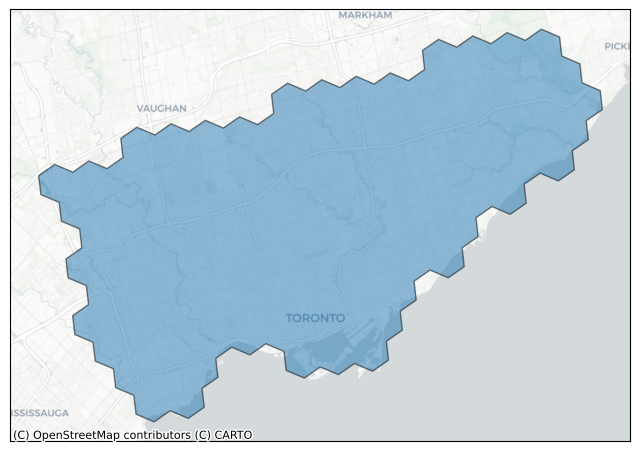

In [117]:
os.chdir('/Users/benpage/Documents/GitHub/r5food/data/')
tor_boundry = gpd.read_file('tor_boundry.geojson')
cell_column = tor_boundry.geometry.apply(lambda x: h3.geo_to_cells(x, res=7))
shape_column = cell_column.apply(h3.cells_to_h3shape)
tor_boundry.geometry = shape_column



hex_cells = create_hex(tor_boundry, 7)
plot_cells(hex_cells)



# df = pd.DataFrame({'h3_id': hex_grid})
# gdf = gpd.GeoDataFrame(
#     df, 
#     geometry=[h3_to_polygon(cell) for cell in hex_grid],
#     crs="EPSG:4326"  # WGS84 coordinate system
# )

# boundry_h3 = h3.geo_to_h3shape(tor_boundry.iloc[0].geometry.__geo_interface__)
# plot_shape_and_cells(boundry_h3, 7)
